In [1]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
ROOT = "media"   # change if needed

# Fields to extract
FIELDS = [
    "mean_ng",
    "Nbw",
    "NDBP",
    "max_disp",
    "max_loss",
    "max_loss_ng2",
    "true_cost"
]

records = []   # list of dicts

for root, dirs, files in os.walk(ROOT):
    if "meta_data.json" in files:
        json_path = os.path.join(root, "meta_data.json")

        # Extract test identifiers
        parts = json_path.split(os.sep)
        test_name = parts[-2]              # e.g., "test0"
        loss_test = parts[-3]              # e.g., "loss_tests0"
        ndbp_index = parts[-4]              # e.g., "ndbp0"
        ng_dir = parts[-5]                 # e.g., "ng10"

        with open(json_path, "r") as f:
            data = json.load(f)

        # Store extracted values
        record = {
            "ng": ng_dir,
            "loss_group": loss_test,
            "ndbp": ndbp_index,
            "test": test_name
        }
        for key in FIELDS:
            record[key] = data.get(key, None)

        records.append(record)

# -----------------------------
# Convert to numpy structured array
# -----------------------------
dtype = [
    ("ng", "U32"),
    ("loss_group", "U32"),
    ("ndbp", "U32"),
    ("test", "U32"),
] + [(field, "f8") for field in FIELDS]

np_array = np.zeros(len(records), dtype=dtype)

for i, rec in enumerate(records):
    np_array[i]["ng"] = rec["ng"]
    np_array[i]["loss_group"] = rec["loss_group"]
    np_array[i]["ndbp"] = rec["ndbp"]
    np_array[i]["test"] = rec["test"]
    for field in FIELDS:
        np_array[i][field] = rec[field]

# Optional: also produce a pandas DataFrame
try:
    import pandas as pd
    df = pd.DataFrame(records)
except ImportError:
    df = None

# Preview
print("Extracted", len(records), "records.")
print(records[:2])       # sample
print(np_array[:2])      # numpy view


Extracted 14242 records.
[{'ng': 'ng24', 'loss_group': 'loss_tests11', 'ndbp': 'ndbp2', 'test': 'test16', 'mean_ng': 25.416226723161817, 'Nbw': 0.010364478799980722, 'NDBP': 0.26342594304771416, 'max_disp': 1907.4713711238446, 'max_loss': 8.312398963881133, 'max_loss_ng2': 0.012622839554340392, 'true_cost': 0.21605617181197725}, {'ng': 'ng24', 'loss_group': 'loss_tests11', 'ndbp': 'ndbp2', 'test': 'test11', 'mean_ng': 24.471112739672943, 'Nbw': 0.010251522461596156, 'NDBP': 0.250866161911009, 'max_disp': 1737.1654926236906, 'max_loss': 17.010493059447143, 'max_loss_ng2': 0.029086335059342404, 'true_cost': 0.2940058652357582}]
[('ng24', 'loss_tests11', 'ndbp2', 'test16', 25.41622672, 0.01036448, 0.26342594, 1907.47137112,  8.31239896, 0.01262284, 0.21605617)
 ('ng24', 'loss_tests11', 'ndbp2', 'test11', 24.47111274, 0.01025152, 0.25086616, 1737.16549262, 17.01049306, 0.02908634, 0.29400587)]


In [5]:
np_array

array([('ng24', 'loss_tests11', 'ndbp2', 'test16', 25.41622672, 0.01036448, 0.26342594, 1907.47137112,  8.31239896, 0.01262284, 0.21605617),
       ('ng24', 'loss_tests11', 'ndbp2', 'test11', 24.47111274, 0.01025152, 0.25086616, 1737.16549262, 17.01049306, 0.02908634, 0.29400587),
       ('ng24', 'loss_tests11', 'ndbp2', 'test18', 24.00624652, 0.01201007, 0.28831677, 4346.11750336,  5.58430596, 0.00981782, 0.4068947 ),
       ...,
       ('ng26', 'loss_tests13', 'ndbp1', 'test3', 27.14289745, 0.00901015, 0.24456165,  725.83998964, 12.10102901, 0.01634105, 0.08611184),
       ('ng26', 'loss_tests13', 'ndbp1', 'test2', 27.23505736, 0.00834821, 0.2273639 , 1877.00376083, 12.1557905 , 0.01598401, 0.1209783 ),
       ('ng26', 'loss_tests13', 'ndbp1', 'test5',  9.71120119, 0.02992822, 0.29063892, 7598.24745725,  0.71484502, 0.00453462, 1.12378657)],
      dtype=[('ng', '<U32'), ('loss_group', '<U32'), ('ndbp', '<U32'), ('test', '<U32'), ('mean_ng', '<f8'), ('Nbw', '<f8'), ('NDBP', '<f8'), ('

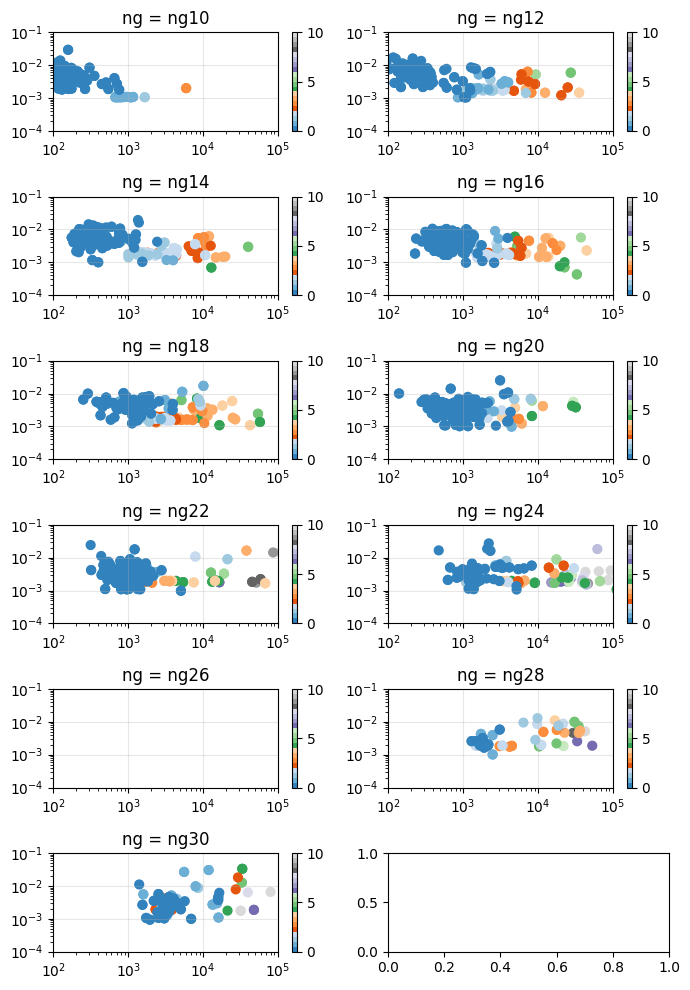

In [7]:
ng_strings = ["ng10","ng12","ng14","ng16","ng18","ng20","ng22","ng24","ng26","ng28","ng30"]

fig, axs = plt.subplots(6, 2, figsize=(7, 10))
for i, ng_string in enumerate(ng_strings):
    mask = (np_array["ng"] == ng_string) & (np_array["ndbp"] == "ndbp0")
    sub = np_array[mask]

    # Extract values
    x = sub["max_disp"]
    y = sub["max_loss_ng2"]
    c = sub["true_cost"]

    # Sort such that smaller c values appear last (on top)
    sort_idx = np.argsort(c)[::-1]  # sort descending so smallest c last (will be plotted last, appear "on top")
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    c_sorted = c[sort_idx]

    axs[i//2, i%2].grid(True, alpha=0.3)
    sc = axs[i//2, i%2].scatter(x_sorted, y_sorted, c=c_sorted, s=40, cmap='tab20c', vmin=0, vmax=10)
    plt.colorbar(sc, ax=axs[i//2, i%2])

    axs[i//2, i%2].set_xscale("log")
    axs[i//2, i%2].set_yscale("log")
    axs[i//2, i%2].set_xlim(1e2, 1e5)
    axs[i//2, i%2].set_ylim(1e-4, 1e-1)
    axs[i//2, i%2].set_title(f"ng = {ng_string}")

plt.tight_layout()
plt.show()



In [11]:
# Find all missing combinations of (ng, ndbp, loss_group, test)
ng_strings = [f"ng{ng}" for ng in range(10, 31, 2)]  # ng10, ng12, ..., ng30
ndbp_strings = [f"ndbp{i}" for i in range(5)]        # ndbp0, ..., ndbp4
loss_groups = [f"loss_tests{i}" for i in range(14)]  # loss_tests0, ..., loss_tests13
test_strings = [f"test{i}" for i in range(20)]       # test0, ..., test19

import itertools

# Build all expected keys as tuple (ng, loss_group, ndbp, test)
all_expected = set(itertools.product(ng_strings, loss_groups, ndbp_strings, test_strings))

# Find present keys in np_array
present = set(zip(np_array['ng'], np_array['loss_group'], np_array['ndbp'], np_array['test']))

missing = sorted(all_expected - present)

print(f"Total possible combinations: {len(all_expected):,}")
print(f"Combinations present: {len(present):,}")
print(f"Combinations missing: {len(missing):,}")

# Group output for easier reading:
from collections import defaultdict

# Organize by ng, ndbp, loss_group for ease of inspection
missing_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for ng, loss_group, ndbp, test in missing:
    missing_dict[ng][ndbp][loss_group].append(test)

# Print report by ng
for ng in ng_strings:
    print(f"\nNG: {ng}")
    for ndbp in ndbp_strings:
        summary_row = []
        for loss_group in loss_groups:
            num_missing = len(missing_dict[ng][ndbp][loss_group])
            # List missing test numbers for this group if any are missing
            if num_missing > 0:
                summary_row.append(f"{loss_group}({num_missing})")
        if summary_row:
            print(f"  {ndbp}: " + ", ".join(summary_row))

print("\nDetailed listing (first 20 missing combos):")
for tup in missing[:20]:
    print(tup)

# --- ADDED SECTION: Report indexes from arrayInputs.csv that are missing tests ---

# These files were generated from a csv like "@arrayInputs.csv (1-9) " where first 3 numbers correspond to
# (LOSS_INDEX, NDBP_INDEX, NG_INDEX), which maps to loss_group, ndbp_string, ng_strings index respectively.
# We want to find which indexing triplets have any missing test.

# Create mapping from label to index
ng_string_to_index = {f"ng{ng}": idx for idx, ng in enumerate(range(10, 31, 2))}
ndbp_string_to_index = {f"ndbp{i}": i for i in range(5)}
loss_group_to_index = {f"loss_tests{i}": i for i in range(14)}

# For each missing file, collect by (loss_group_index, ndbp_index, ng_index)
index_key_missing = defaultdict(set)
for ng, loss_group, ndbp, test in missing:
    ng_idx = ng_string_to_index[ng]
    ndbp_idx = ndbp_string_to_index[ndbp]
    loss_idx = loss_group_to_index[loss_group]
    index_key_missing[(loss_idx, ndbp_idx, ng_idx)].add(test)

# Only keep the index combinations (loss_idx, ndbp_idx, ng_idx) that are missing *any* test
index_keys_with_missing = sorted(index_key_missing.keys())

print("\nIndexing triplets from arrayInputs.csv (LOSS_INDEX, NDBP_INDEX, NG_INDEX) with at least one missing test entry:")
print(f"(total: {len(index_keys_with_missing)})")
for idx_comb in index_keys_with_missing:
    tests_missing = sorted(index_key_missing[idx_comb])
    print(f"  Indexes {idx_comb}: Missing count={len(tests_missing)}, Tests missing = {tests_missing[:5]}" +
          (" ..." if len(tests_missing) > 5 else ""))

# If desired: Print for pasting back into a csv or looping
print("\nAs tuple list for code:")
print(index_keys_with_missing[:30])

# ---- CREATE NEW CSV FOR THESE INDEXES WITH TWO SEEDS ----
import csv

outfile = "arrayInputs2.csv"
seed_vals = [42, 69]

with open(outfile, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["LOSS_INDEX", "NDBP_INDEX", "NG_INDEX", "SEED"])
    for (loss_idx, ndbp_idx, ng_idx) in index_keys_with_missing:
        for seed in seed_vals:
            writer.writerow([loss_idx, ndbp_idx, ng_idx, seed])

print(f"\nWrote {len(index_keys_with_missing)*2} lines to {outfile}.")


Total possible combinations: 15,400
Combinations present: 14,242
Combinations missing: 1,158

NG: ng10
  ndbp2: loss_tests2(20)

NG: ng12
  ndbp2: loss_tests2(20)

NG: ng14
  ndbp0: loss_tests12(6)
  ndbp2: loss_tests2(20)

NG: ng16
  ndbp1: loss_tests2(20)
  ndbp2: loss_tests2(20), loss_tests13(14)

NG: ng18
  ndbp1: loss_tests2(20)
  ndbp2: loss_tests2(20)

NG: ng20
  ndbp1: loss_tests2(20)
  ndbp2: loss_tests2(20)
  ndbp3: loss_tests0(20)

NG: ng22
  ndbp0: loss_tests1(11), loss_tests4(6)
  ndbp1: loss_tests2(20), loss_tests11(12)
  ndbp2: loss_tests2(20)

NG: ng24
  ndbp0: loss_tests1(15), loss_tests3(16), loss_tests7(10), loss_tests8(10), loss_tests9(10), loss_tests10(10), loss_tests11(10), loss_tests12(10)
  ndbp1: loss_tests2(20)
  ndbp2: loss_tests2(20)
  ndbp4: loss_tests12(6)

NG: ng26
  ndbp0: loss_tests0(20), loss_tests1(20), loss_tests2(20), loss_tests3(20), loss_tests4(20), loss_tests5(20), loss_tests6(20), loss_tests7(20), loss_tests8(20), loss_tests9(20), loss_tests10(2